In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
normalizeUL2(u,M) = u.*sign.(sum(u))./ sqrt(u'*M*u);

In [3]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots

In [4]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [5]:
# Parameters
grid_resolution        = 200
quadrature_order       = 5
ϵ                      = 2                # perturbation
nev                    = 10
t_initial              = minimum(Time)
t_end                  = t_initial+90     # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5();

In [6]:
T(x, param) = flow(interp_rhs, x, [t_initial, t_end + param], p=UV,
        tolerance=solver_tolerance,solver=solver)[end]

T (generic function with 1 method)

In [7]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [8]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [9]:
@time D⁰ = assembleStiffnessMatrix(ctx)
@time D¹ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,0))
K = 0.5(D⁰+D¹)
K = applyBCS(ctx,K,bdata);

  0.471658 seconds (1.84 M allocations: 122.655 MiB)
 17.709892 seconds (51.92 M allocations: 2.981 GiB, 6.24% gc time)


In [10]:
D¹ϵ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,-ϵ))
Kϵ = 0.5(D⁰+D¹ϵ)
Kϵ = applyBCS(ctx,Kϵ,bdata);

In [11]:
# assemble the linear response matrix L
@time L = adaptiveTOCollocationLinearResponseMatrix(ctx, T, 0)
L = applyBCS(ctx,L,bdata);

 22.204472 seconds (33.91 M allocations: 2.253 GiB, 1.84% gc time)


In [12]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM, nev=nev)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀)
λ₀ = real.(λ₀)
for i in 1:size(u₀)[2]
    u₀[:,i] = normalizeUL2(u₀[:,i],M)
end

  4.100470 seconds (8.89 M allocations: 657.279 MiB, 2.43% gc time)


In [13]:
# calculate the exact uϵ
λϵ, uϵ = eigs(Kϵ, M, which=:SM, nev=nev)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ)
λϵ = real.(λϵ)
for i in 1:size(uϵ)[2]
    uϵ[:,i] = normalizeUL2(uϵ[:,i],M)
end

In [14]:
# solve the system for the derivative u_dot
u_dot = zero(u₀)
λ_dot = zero(λ₀)
for i in 1:size(u₀)[2] 
    @time u_dot[:,i], λ_dot[i] = getLinearResponse(u₀[:,i],λ₀[i],M,K,L)
end

  2.686827 seconds (4.12 M allocations: 590.921 MiB, 9.89% gc time)
  1.365924 seconds (65.91 k allocations: 394.769 MiB, 11.24% gc time)
  1.212052 seconds (296 allocations: 391.135 MiB, 0.74% gc time)
  1.197151 seconds (296 allocations: 391.135 MiB, 0.52% gc time)
  1.200518 seconds (296 allocations: 391.135 MiB, 0.52% gc time)
  1.187490 seconds (296 allocations: 391.135 MiB, 0.47% gc time)
  1.209934 seconds (296 allocations: 391.135 MiB, 0.36% gc time)
  1.190657 seconds (296 allocations: 391.135 MiB, 0.38% gc time)
  1.196351 seconds (296 allocations: 391.135 MiB, 0.39% gc time)
  1.181276 seconds (296 allocations: 391.135 MiB, 0.41% gc time)


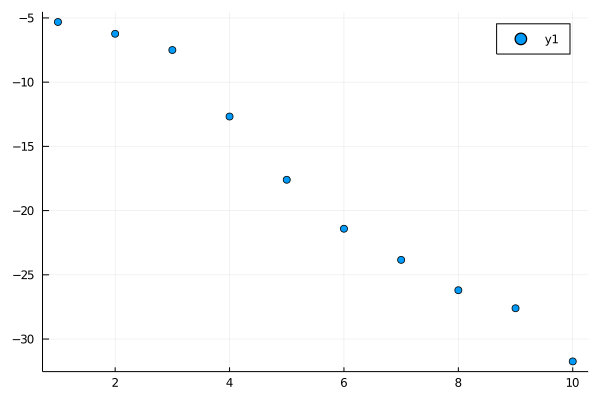

In [15]:
#select number of evs
Plots.scatter(1:nev,λ₀)

In [16]:
nev = 3
u₀ = u₀[:,1:nev]
λ₀ = λ₀[1:nev]
uϵ = uϵ[:,1:nev]
λϵ = λϵ[1:nev]
u_dot = u_dot[:,1:nev]
λ_dot = λ_dot[1:nev];

In [17]:
for i in 1:nev
    print("exact ev"*string(i)*": "*string(λϵ[i])*
        "\t predicted ev"*string(i)*": "*string(λ₀[i] + ϵ*λ_dot[i])*
        "\t relative error: "*string(abs(λ₀[i] + ϵ*λ_dot[i] - λϵ[i])/abs(λϵ[i]))*"\n")
end

exact ev1: -5.236730671345142	 predicted ev1: -5.379845708285343	 relative error: 0.02732908104732442
exact ev2: -6.137567151310871	 predicted ev2: -6.33422297351576	 relative error: 0.03204133125661799
exact ev3: -7.137306018948783	 predicted ev3: -7.852955771373968	 relative error: 0.10026889004411635
exact ev4: -12.480111632758799	 predicted ev4: -12.8674049080216	 relative error: 0.031032837418393133
exact ev5: -17.626942873555244	 predicted ev5: -17.578894416633794	 relative error: 0.0027258531026122614


In [18]:
color =    :balance
xticks =   -4:2:6
yticks =   -34:2:-28
colorbar = :left
cmins =     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,]
cmaxs =     -cmins
cmins_lr =  [-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,-0.2, -0.2, -0.2, -0.2,]
cmaxs_lr =  -cmins_lr;

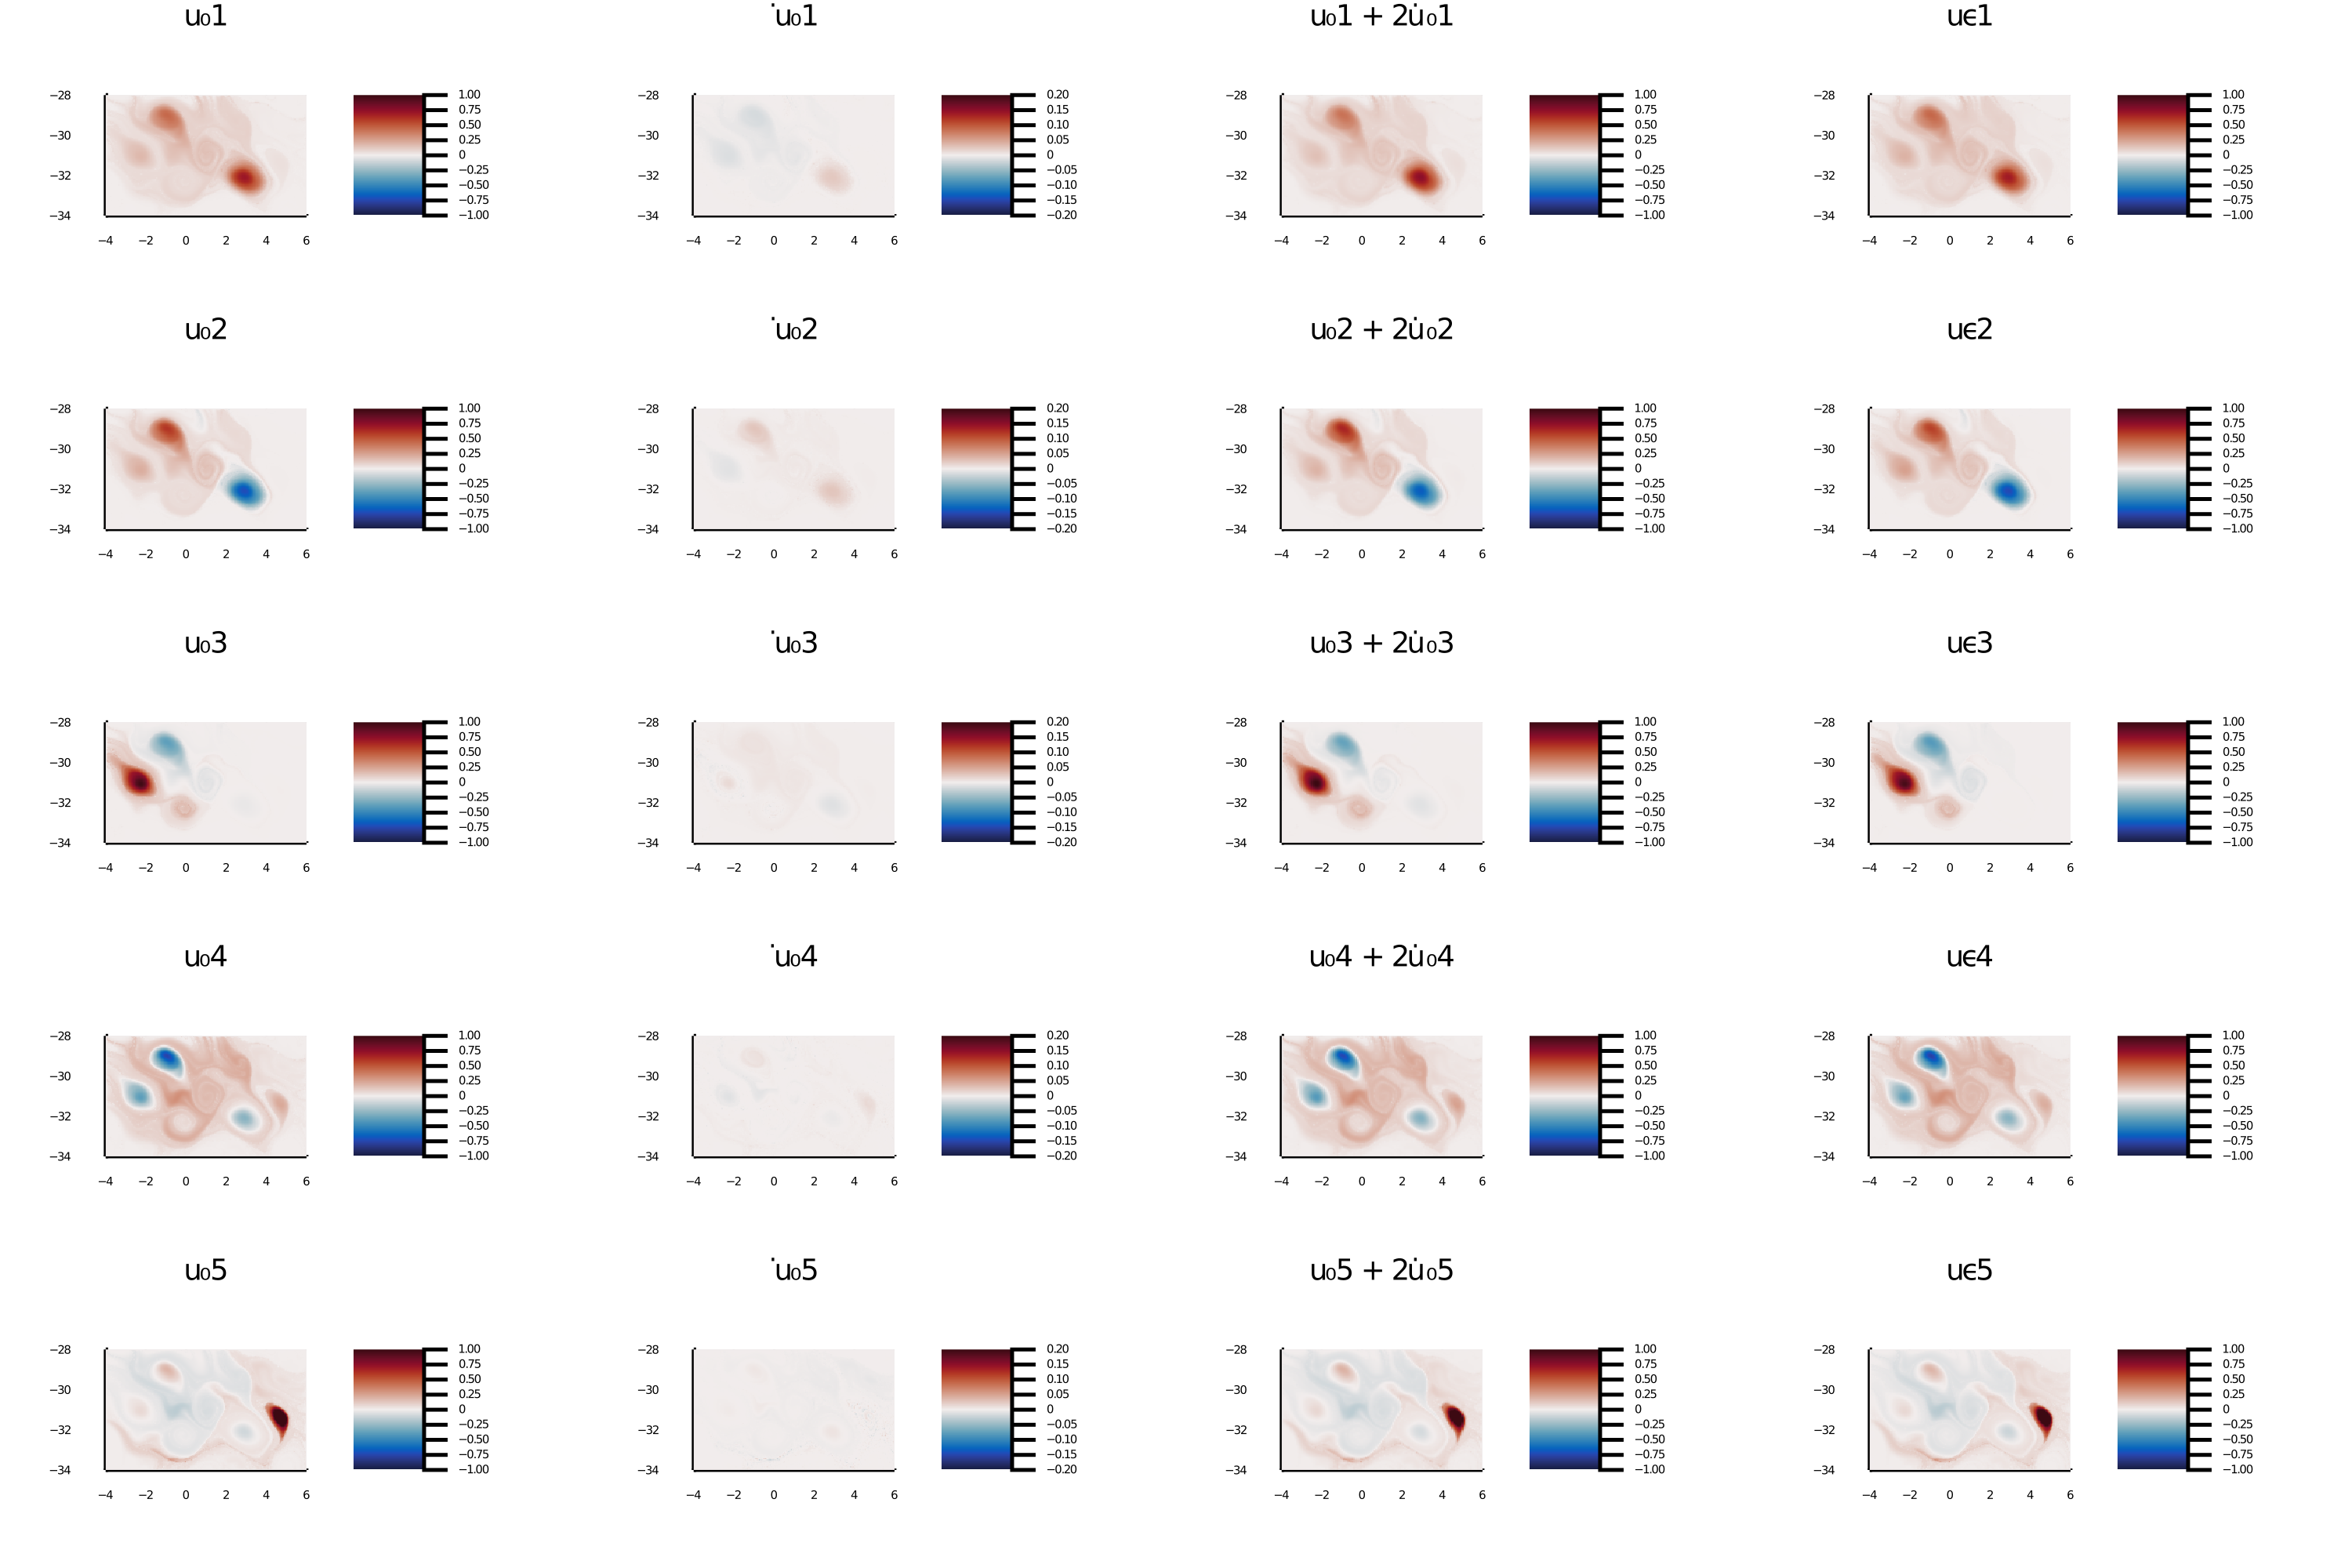

In [19]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, u₀[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="u₀"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u_dot[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="̇u₀"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u₀[:,i] + ϵ*u_dot[:,i],  lat_resolution, grid_resolution, bdata=bdata,
            title="u₀"*string(i)*" + $(ϵ)u̇ ₀"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, uϵ[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="uϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [20]:
#limit ourselves to one ev for plotting etc.
ev = 1

5

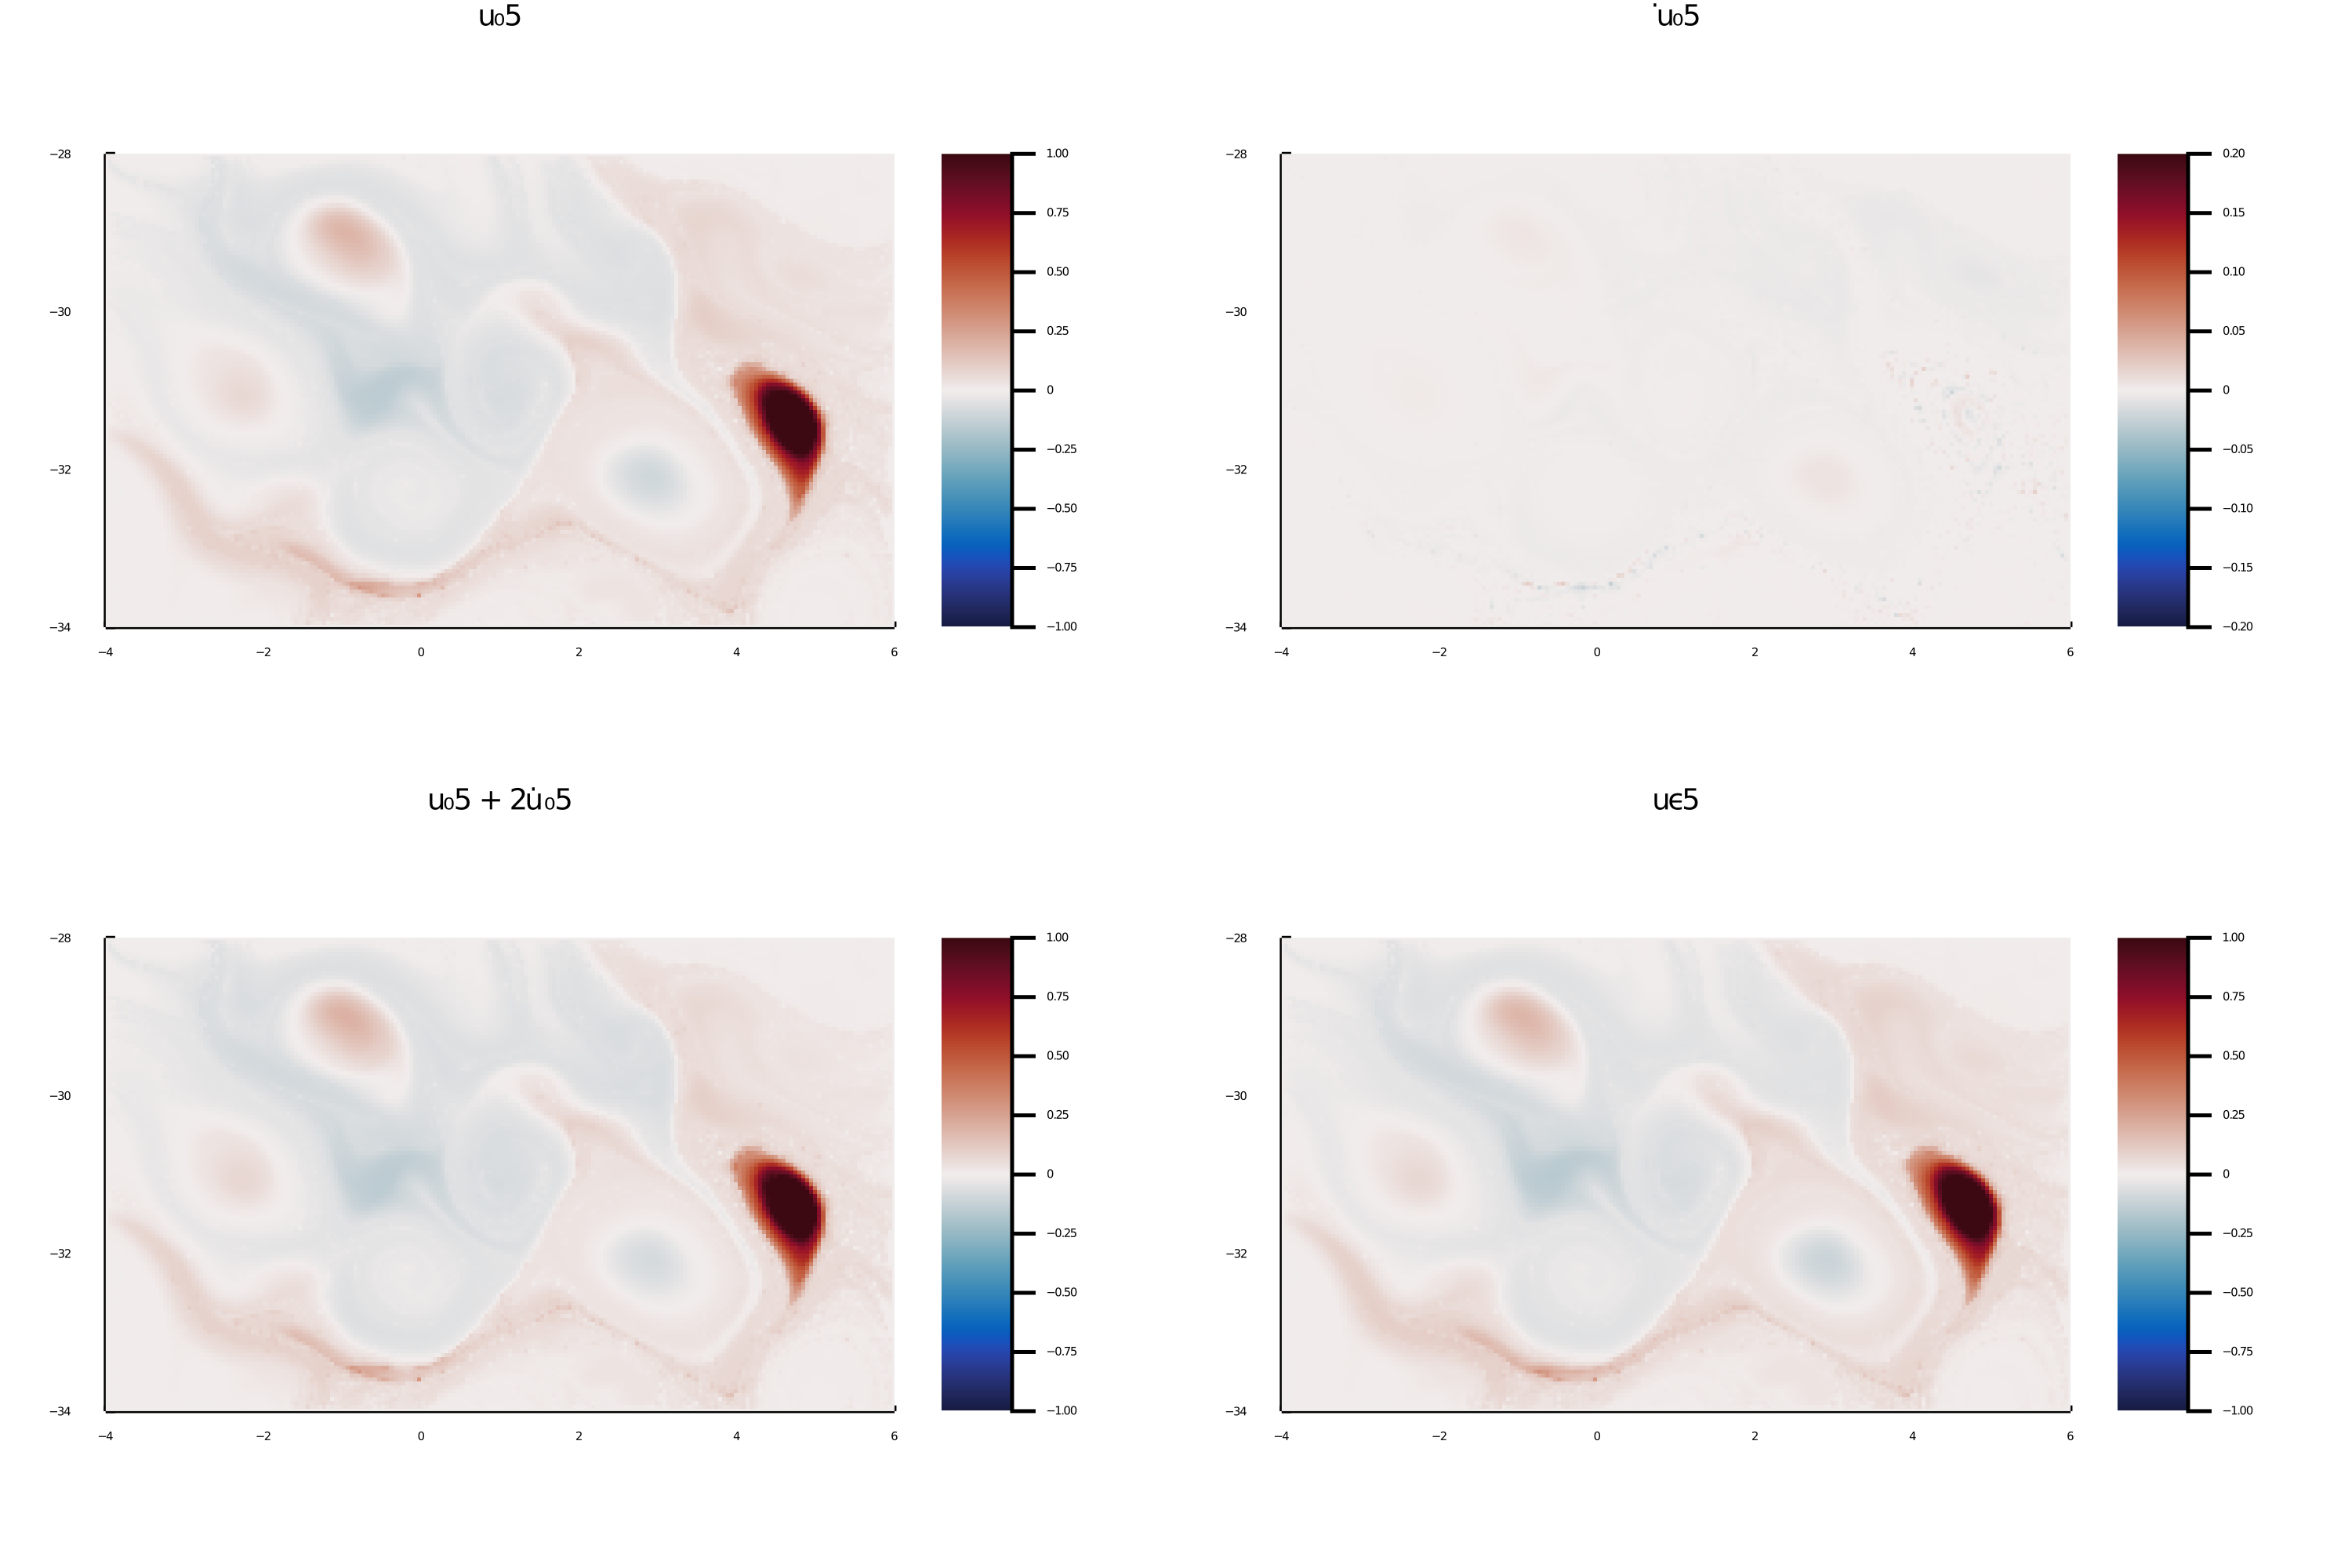

In [21]:
plots = []
push!(plots,plot_u(ctx, u₀[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="u₀"*string(ev), 
            colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, u_dot[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="̇u₀"*string(ev), 
    colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="u₀"*string(ev)*" + $(ϵ)u̇ ₀"*string(ev), 
colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, uϵ[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="uϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

## Contour Plots

In [22]:
using Contour

In [23]:
import Main.CoherentStructures:dynamic_cheeger_value
dynamic_cheeger_value(c) = dynamic_cheeger_value(ctx,c,x->T(x,0);tolerance=1e-10)

dynamic_cheeger_value (generic function with 2 methods)

In [24]:
# Just here to compare with the matlab function

function isClosed(curve)
   return Main.CoherentStructures.closeCurve(ctx,curve,tolerance=1e-10) == curve
end

function dynamic_cheeger_value_matlab(curve)
    image_curve   = Main.CoherentStructures.apply2curve(x->T(x,ϵ),curve)
    
    if !isClosed(curve) || !isClosed(image_curve)
        return Inf
    end
    
    return 0.5(Main.CoherentStructures.getLength(curve)/Main.CoherentStructures.getEuclideanArea(ctx,curve,tolerance=1e-10) +
        Main.CoherentStructures.getLength(image_curve)/Main.CoherentStructures.getEuclideanArea(ctx,image_curve,tolerance=1e-10))
end

dynamic_cheeger_value_matlab (generic function with 1 method)

In [25]:
# resoultion for the levelset methods (default should be 'nothing', that way the grid resolution is used)
x_resolution = 500
y_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*x_resolution));

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.14709777389610695)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.09882797835389415)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.09721898516915373)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.09560999198441329)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.09400099879967287)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.09239200561493244)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.09078301243019202)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.08917401924545158)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.087

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.017019530947416584)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.01862852413215701)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.02023751731689744)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.021846510501637866)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.02345550368637829)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.025064496871118717)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.026673490055859145)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.028282483240599572)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0298914

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13447603343346776)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13608502661820818)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1376940198029486)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13930301298768902)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.14091200617242944)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1425209993571699)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1441299925419103)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.14573898572665073)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.147347978911391

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2519325359195189)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2535415291042593)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.25515052228899976)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2567595154737402)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2583685086584806)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.25997750184322105)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.26158649502796144)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2631954882127019)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.26480448139744234

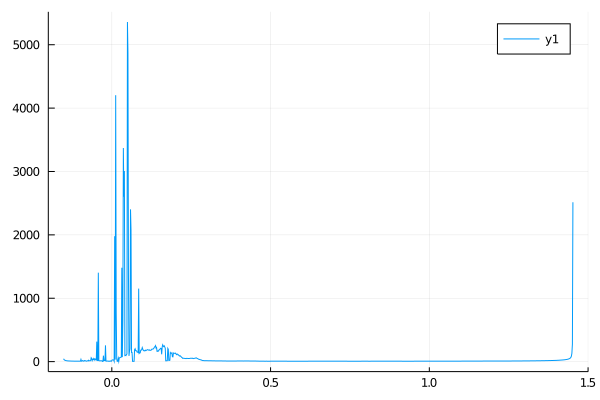

In [26]:
minU = minimum(u₀[:,ev])
maxU = maximum(u₀[:,ev])
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[2:end-1],values[2:end-1])
Plots.plot!(fmt=:png,dpi=100)

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0003003003003003003)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0006006006006006006)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0009009009009009009)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0012012012012012011)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0015015015015015015)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0018018018018018018)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.002102102102102102)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.002402402402402

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.021621621621621623)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.02192192192192192)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.022222222222222223)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.02252252252252252)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.022822822822822823)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.02312312312312312)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.023423423423423424)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.023723723723723725)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0240240

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.043243243243243246)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04354354354354354)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04384384384384384)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.044144144144144144)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.044444444444444446)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04474474474474475)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04504504504504504)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.045345345345345345)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04564564

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06486486486486487)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06516516516516517)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06546546546546547)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06576576576576576)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06606606606606606)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06636636636636636)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06666666666666667)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06696696696696697)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.067267267267

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08648648648648649)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0867867867867868)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08708708708708708)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08738738738738738)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08768768768768768)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08798798798798799)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08828828828828829)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08858858858858859)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0888888888888

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1084084084084084)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1087087087087087)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.109009009009009)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.10930930930930931)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.10960960960960961)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.10990990990990991)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11021021021021021)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11051051051051052)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1108108108108108

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13003003003003002)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13033033033033034)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13063063063063063)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13093093093093094)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13123123123123123)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13153153153153152)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13183183183183184)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13213213213213212)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.132432432432

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15195195195195196)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15225225225225225)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15255255255255254)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15285285285285286)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15315315315315314)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15345345345345346)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15375375375375375)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15405405405405406)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.154354354354

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1735735735735736)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17387387387387387)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17417417417417416)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17447447447447448)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17477477477477477)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17507507507507508)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17537537537537537)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17567567567567569)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1759759759759

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1954954954954955)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.19579579579579579)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1960960960960961)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1963963963963964)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1966966966966967)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.196996996996997)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1972972972972973)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1975975975975976)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.19789789789789788)
└

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21771771771771772)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.218018018018018)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21831831831831833)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21861861861861862)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21891891891891893)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21921921921921922)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2195195195195195)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21981981981981982)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.220120120120120

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.23933933933933935)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.23963963963963963)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.23993993993993995)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24024024024024024)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24054054054054055)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24084084084084084)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24114114114114113)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24144144144144145)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.241741741741

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.26096096096096094)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.26126126126126126)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2615615615615616)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2618618618618619)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.26216216216216215)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.26246246246246246)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2627627627627628)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.26306306306306304)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.263363363363363

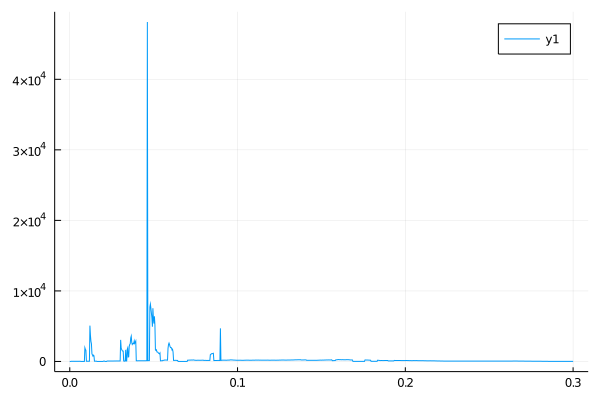

In [27]:
minU = 0
maxU = 0.3
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[1:end],values[1:end])
Plots.plot!(fmt=:png,dpi=100)

In [28]:
best_levelset, best_value = get_minimal_levelset(
    ctx,u₀[:,ev],dynamic_cheeger_value,
    x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata,
    n_candidates=1000,min=0)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.001455305750671289)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.002910611501342578)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.004365917252013867)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.048025089772152536)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04948039552282383)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.050935701273495115)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.05239100702416641)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:15

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.09750548529497637)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.09896079104564766)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.10041609679631895)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.10187140254699023)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155


┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1455305750671289)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1469858808178002)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1484411865684715)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.14989649231914276)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ W

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.19646627634062402)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.19792158209129532)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1993768878419666)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2008321935926379)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ 

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24594667186344785)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24740197761411914)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24885728336479043)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2503125891154617)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌

Dynamic Cheeger value:	3.924767879680597
Levelset:		0.008731834504027734


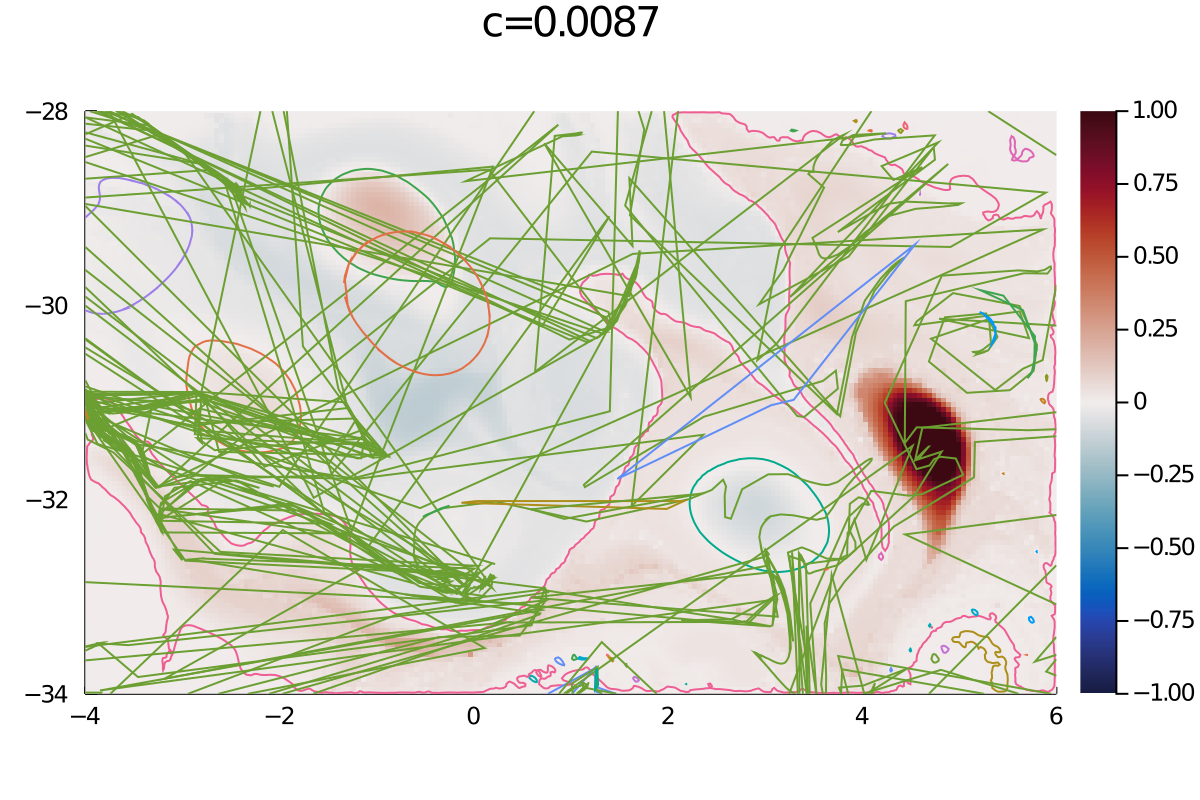

In [29]:
c_best = level(best_levelset)
plot_u(ctx, u₀[:,ev],  lon_resolution, lat_resolution, title="c=$(round(c_best,digits=4))", bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(best_levelset)
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false)

In [30]:
using PyCall
using PyPlot

In [31]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

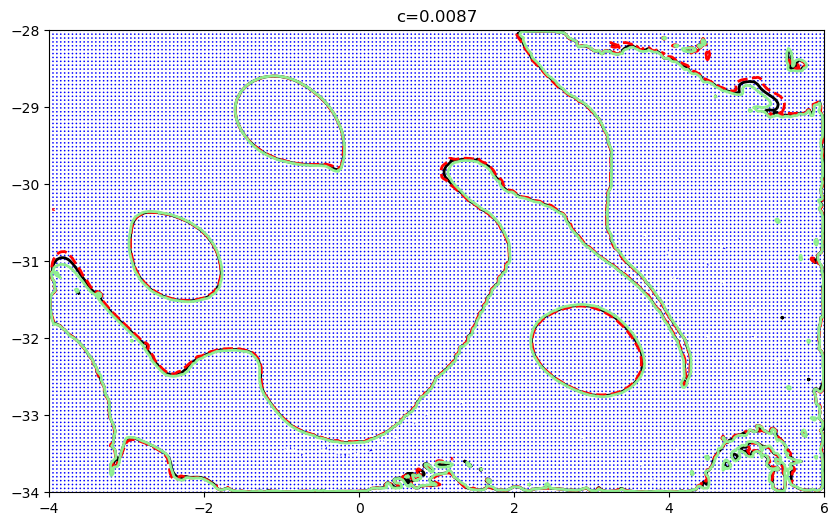

In [32]:
plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
plot_vectorfield(get_levelset_evolution(ctx,u₀[:,ev],u_dot[:,ev],bdata=bdata)...,ax,scale=5,step=1)
curves           = lines(get_levelset(ctx, u₀[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, uϵ[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_predicted = lines(get_levelset(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");

## SEBA

In [33]:
using LinearAlgebra

In [34]:
softThreshold(u,μ) = sign.(u) .* max.(abs.(u) .- μ, 0)
normalizeU(u) = u.*sign.(sum(u))/maximum(u*sign.(sum(u)))
normalizeU(u,v) = u.*sign.(sum(v))/maximum(v*sign.(sum(v)));

In [35]:
μ = 0.99/grid_resolution;

In [36]:
@time S, R = SEBA(u₀,μ=μ,returnR=true,sort=false);

  1.582844 seconds (6.22 M allocations: 558.038 MiB, 5.10% gc time)


In [37]:
order = sortperm([-minimum(S[:,i]) for i in 1:nev]);

In [38]:
# This is the matrix we effectively multiply u₀ with
Rot = inv(qr(u₀).R)*R'

5×5 Array{Float64,2}:
 -0.036437    -0.0222899   -0.0101276   -0.0242621    -0.00370939
  0.0340205   -0.0296343   -0.0112944   -0.0191029    -0.000370392
  0.00117227   0.0187751   -0.0466195    0.000521905  -0.000544348
  0.00640425   0.0278909    0.0110899   -0.0382268    -0.0109812
  0.0010476   -0.00456059  -0.00112037   0.0105525    -0.0488199

In [39]:
S_dot = u_dot*Rot;

In [40]:
Sϵ, Rϵ = SEBA(uϵ,μ=μ,returnR=true,sort=false);

In [41]:
S′ = Matrix(qr(u₀).Q)*R';

In [42]:
Sϵ′ = Matrix(qr(uϵ).Q)*Rϵ';

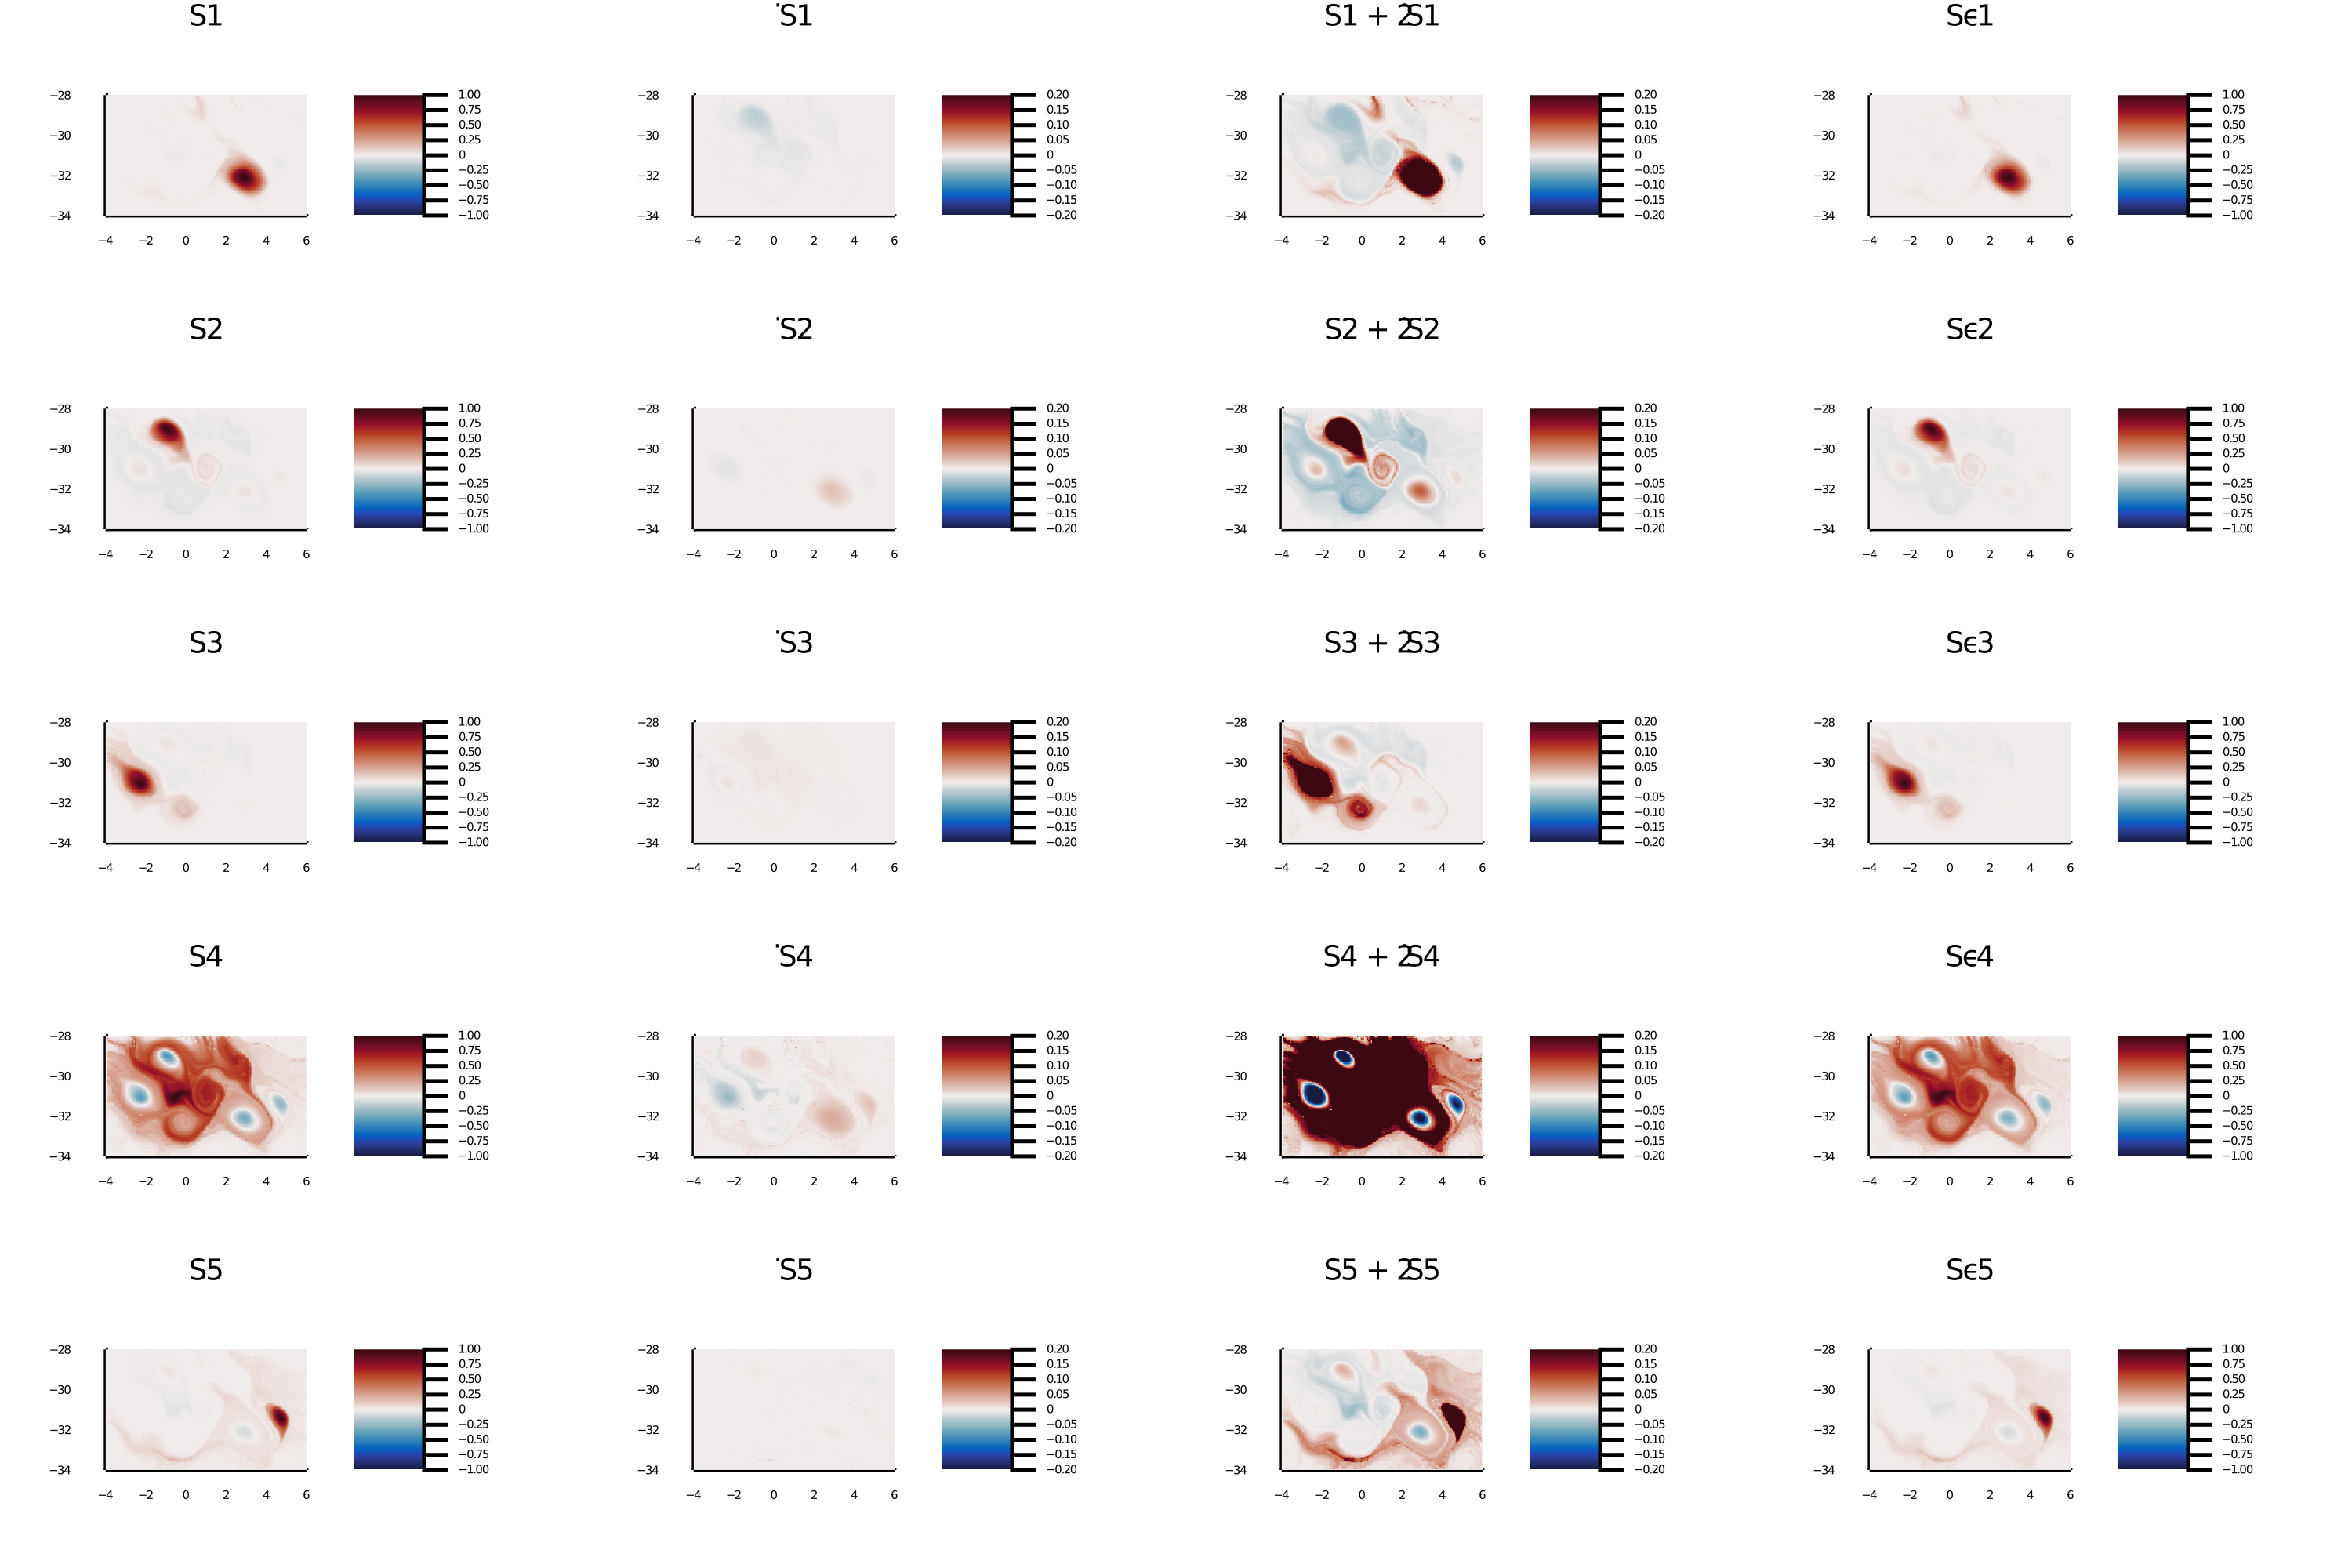

In [43]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, normalizeU(S′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S_dot[:,i],S′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S′[:,i] + ϵ*S_dot[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sϵ′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

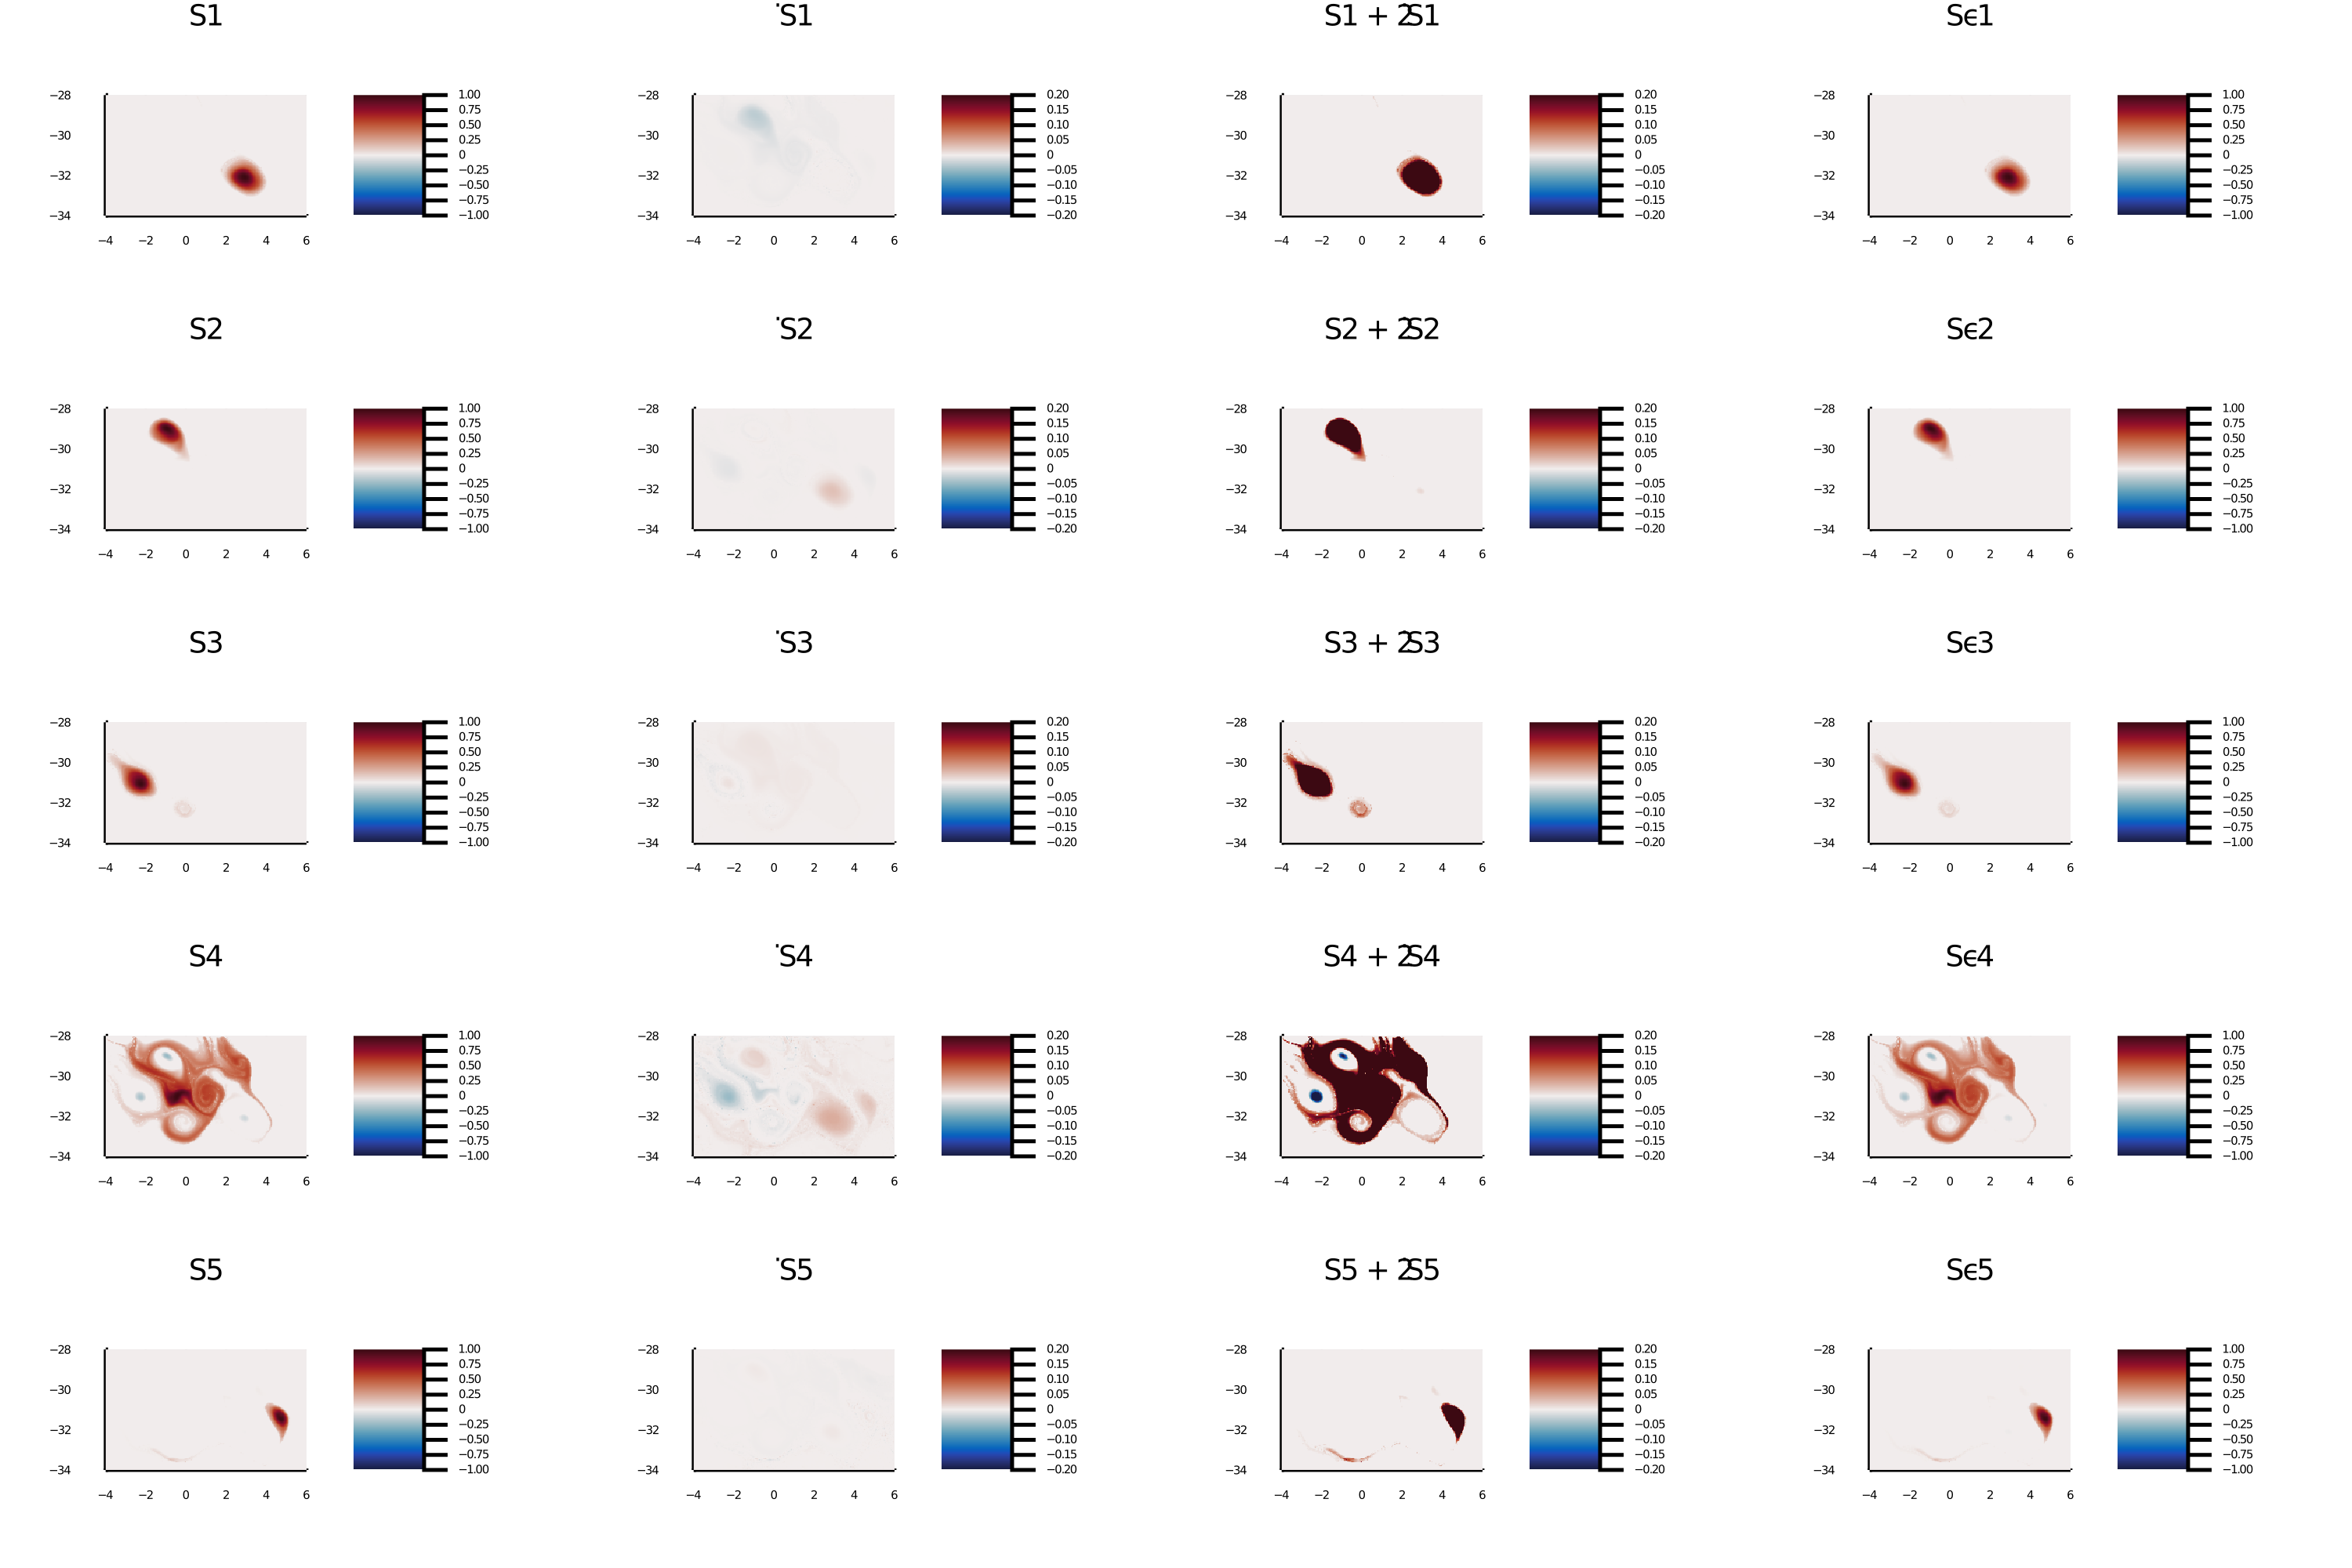

In [44]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S[:,i],  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S_dot[:,i],S′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,i] + ϵ*S_dot[:,i],μ)),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, Sϵ[:,i],  
            lon_resolution, lat_resolution, bdata=bdata,
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

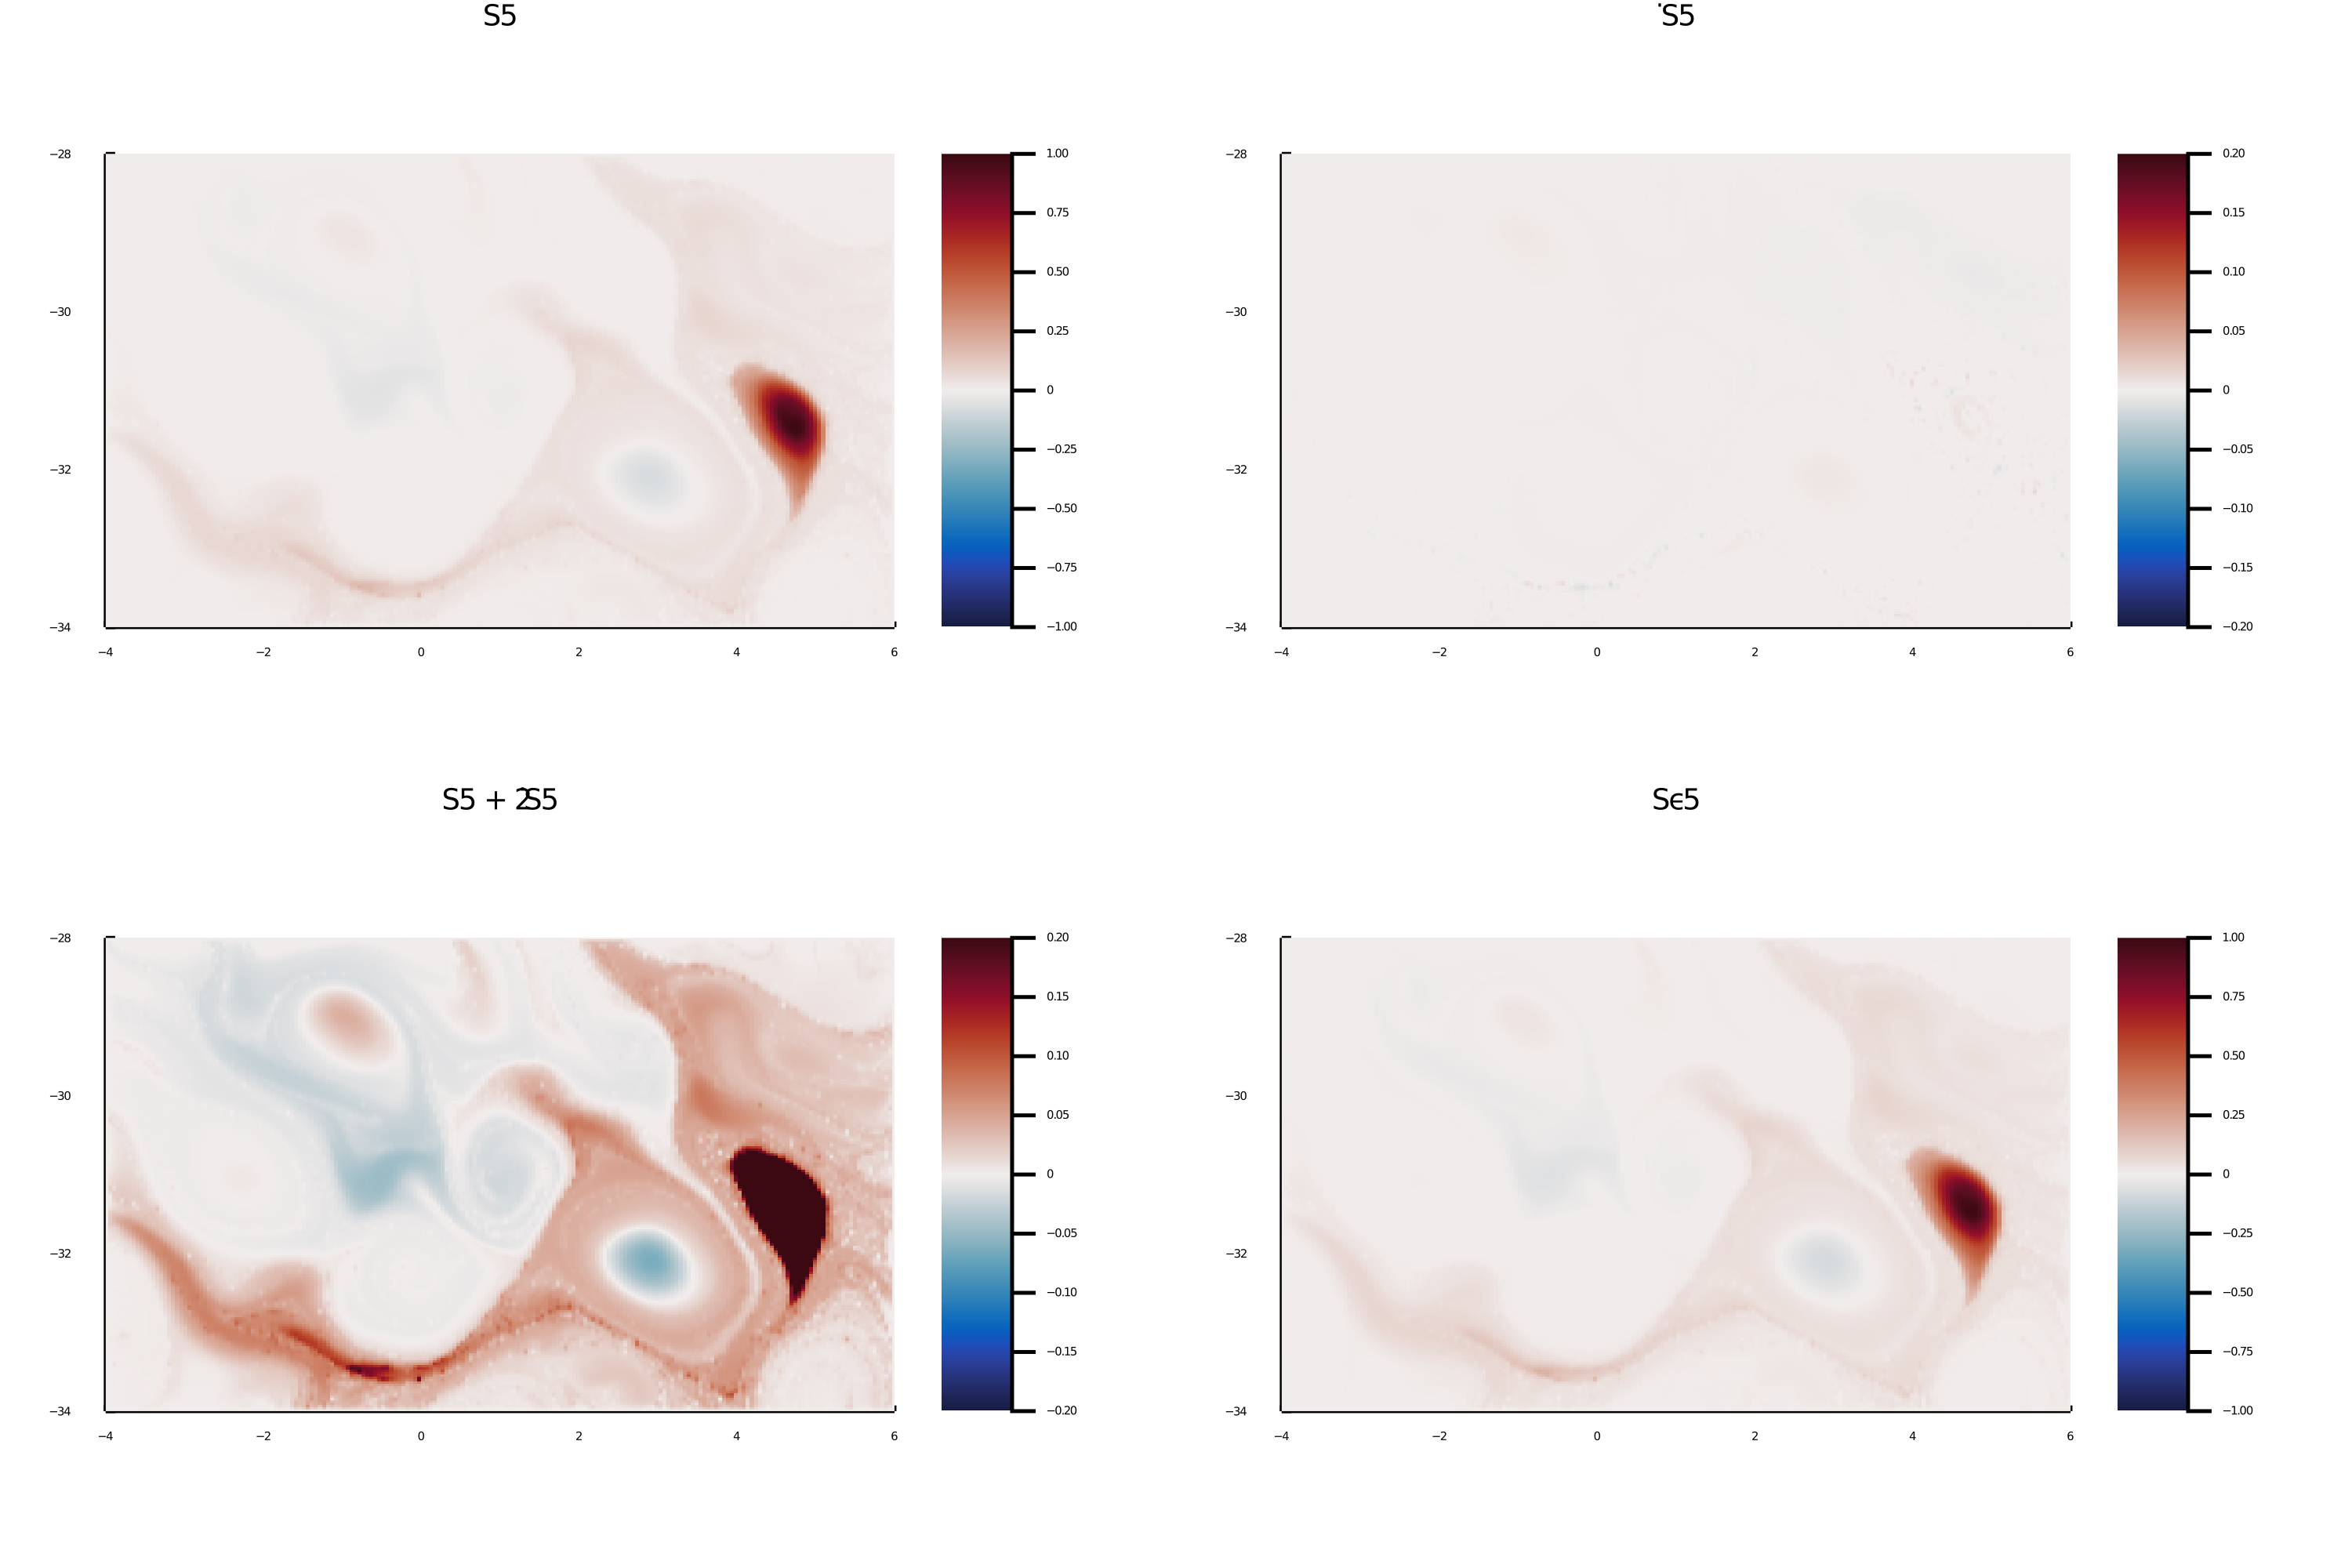

In [45]:
plots = []
push!(plots,plot_u(ctx, normalizeU(S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S_dot[:,ev],S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S′[:,ev] + ϵ*S_dot[:,ev]),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(Sϵ′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

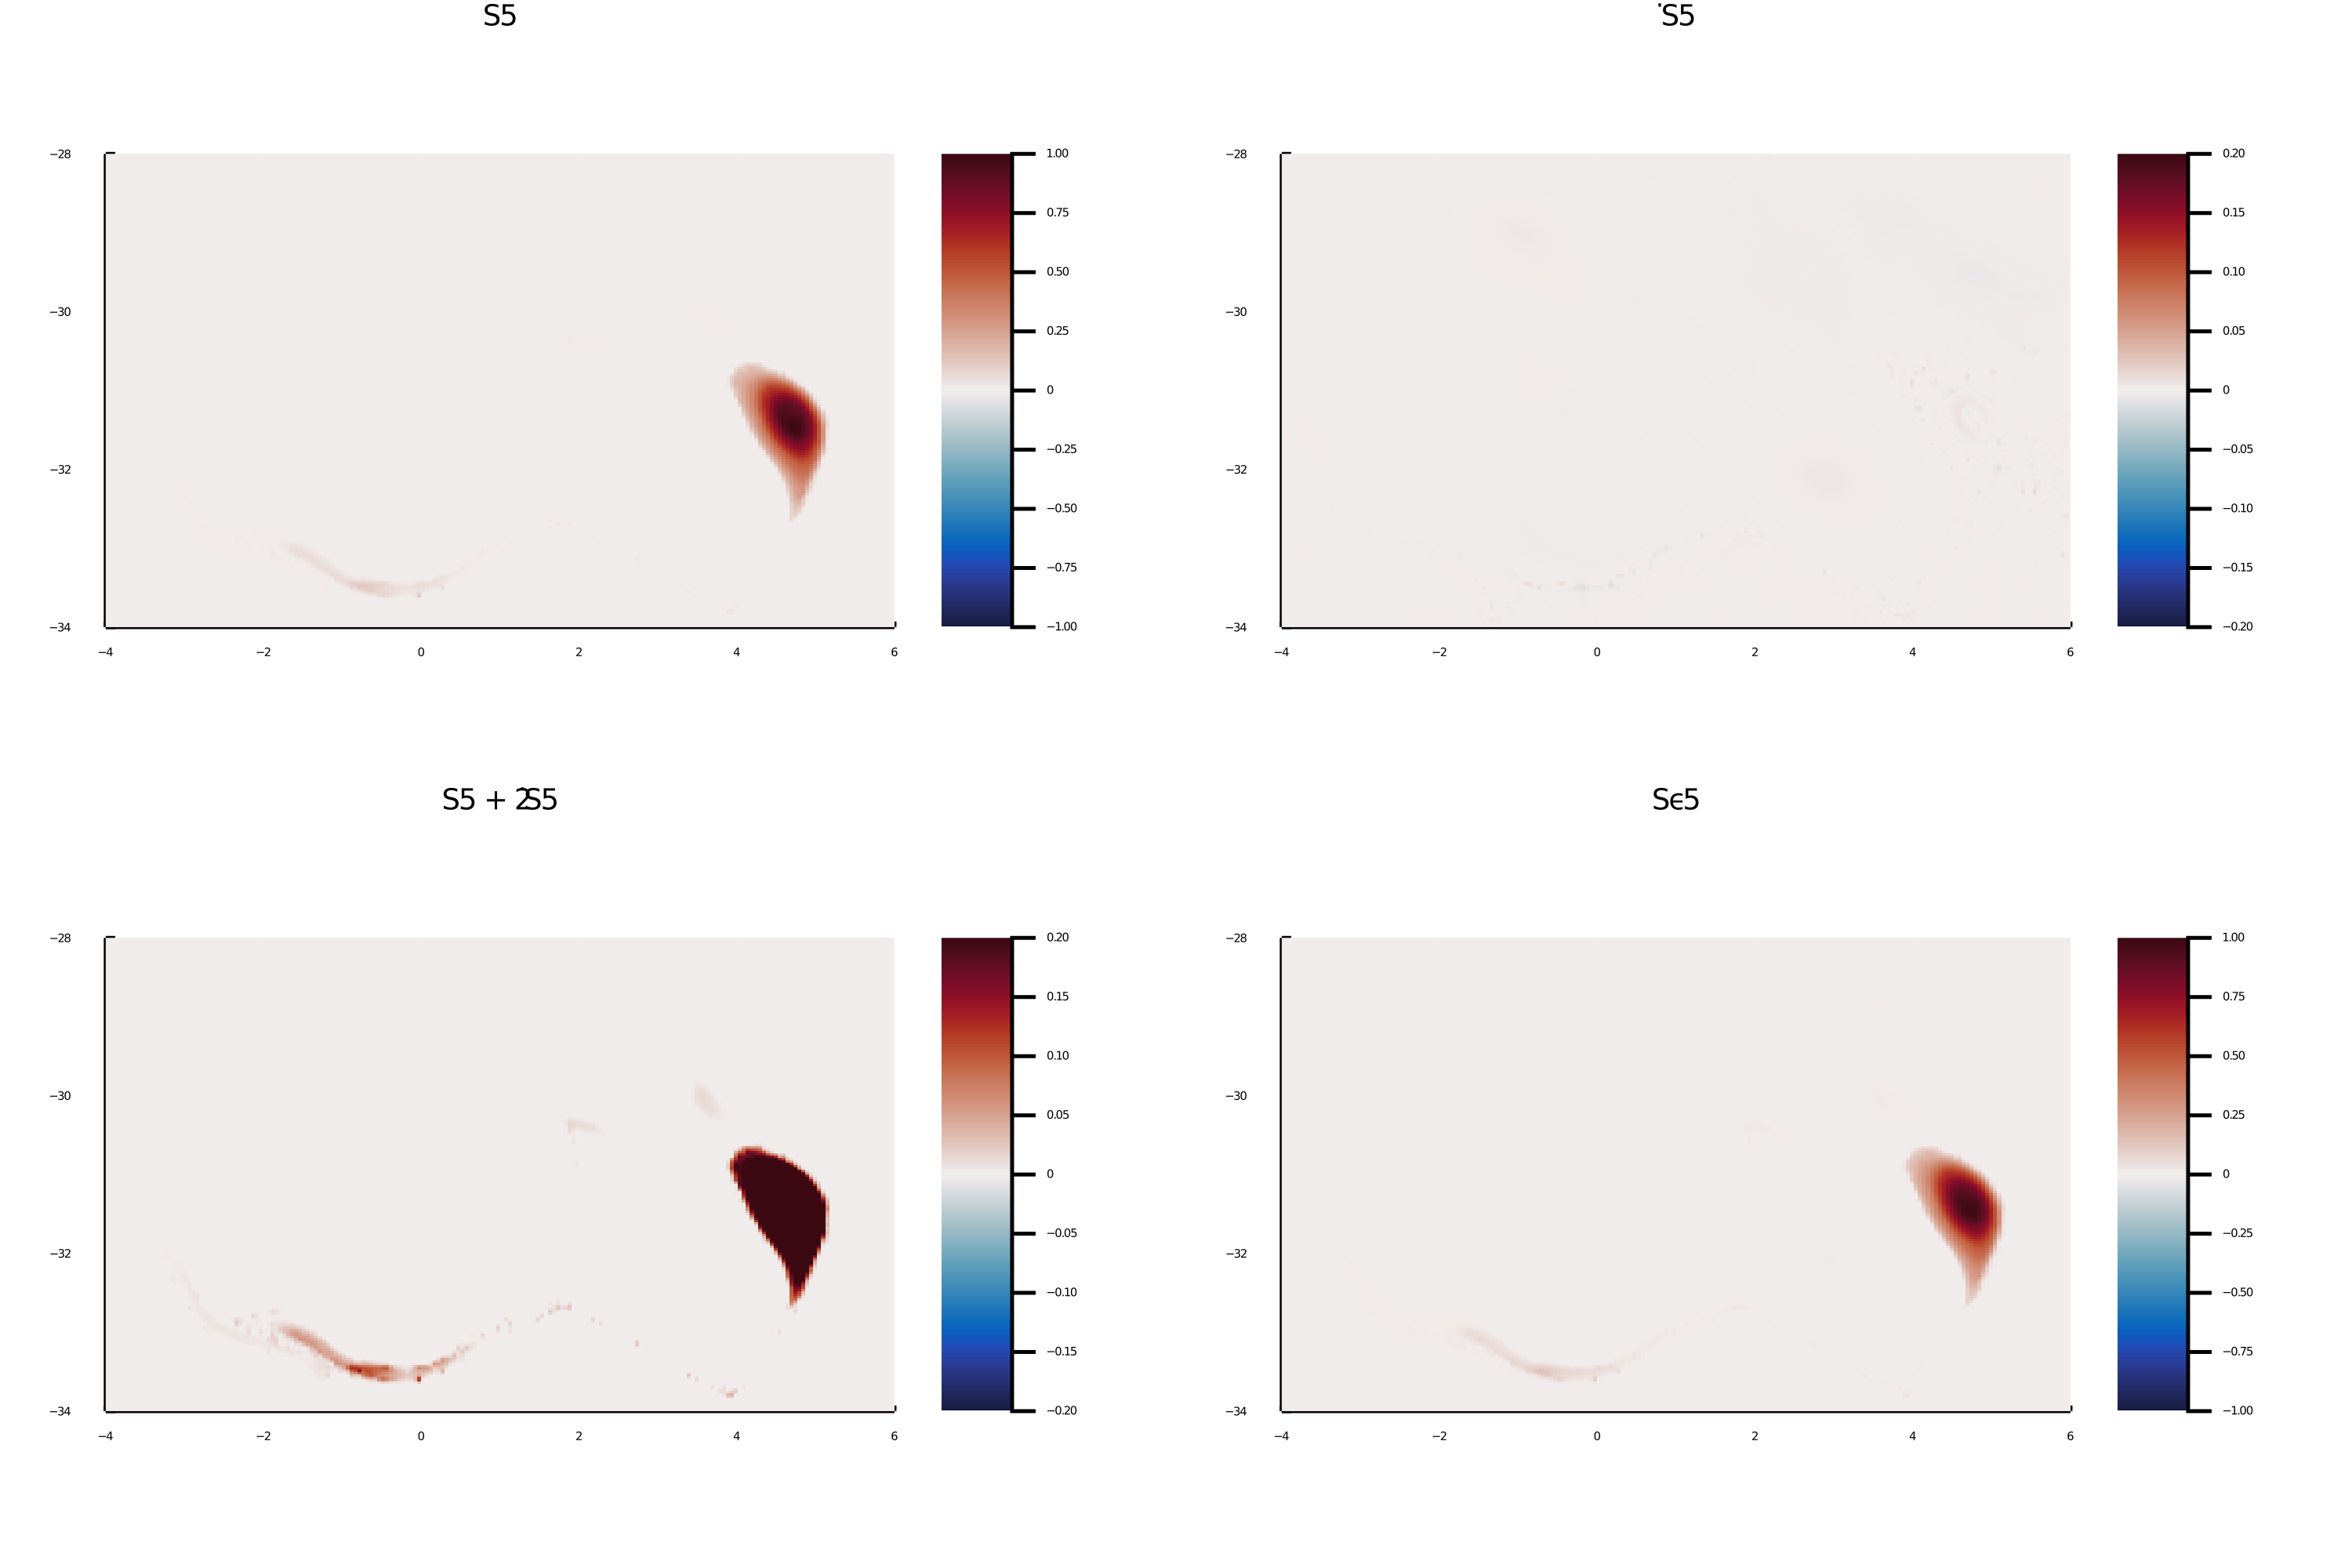

In [46]:
plots = []
push!(plots,plot_u(ctx, S[:,ev],  
        grid_resolution, grid_resolution, 
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S_dot[:,ev],S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, Sϵ[:,ev],  
        grid_resolution, grid_resolution, 
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0008628689598416403)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0018731188395586862)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.002883368719275732)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.003893618598992778)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.004903868478709824)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.005914118358426869)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.006924368238143915)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.007934618117860961)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.00

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.074611110179186)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.07562136005890303)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.07663160993862007)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.07764185981833713)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.07865210969805417)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.07966235957777122)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08067260945748826)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08168285933720532)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08269310921692

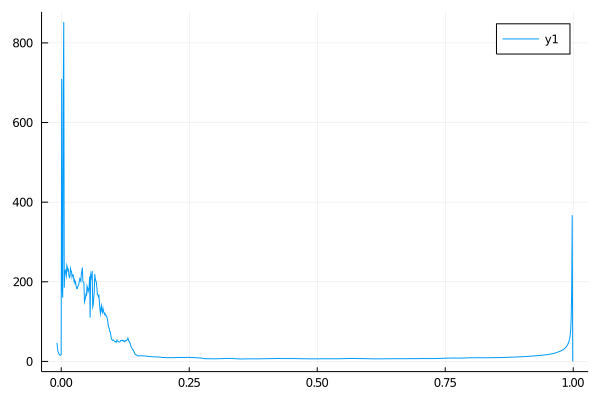

In [47]:
minU = minimum(S[:,ev])
maxU = maximum(S[:,ev])
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,S[:,ev],c,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[2:end-1],values[2:end-1])
Plots.plot!(fmt=:png,dpi=100)

In [48]:
best_levelset, best_value = get_minimal_levelset(
    ctx,S[:,ev],dynamic_cheeger_value,
    x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata,
    n_candidates=1000,min=0)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.001001001001001001)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.002002002002002002)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.003003003003003003)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.03303303303303303)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.03403403403403404)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.035035035035035036)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.036036036036036036)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:15

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06906906906906907)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.07007007007007007)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.07107107107107107)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.07207207207207207)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155


┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1031031031031031)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1041041041041041)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.10510510510510511)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1061061061061061)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ W

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13713713713713713)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13813813813813813)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13913913913913914)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.27627627627627627)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155


Dynamic Cheeger value:	6.220862999364112
Levelset:		0.3533533533533533


In [49]:
c_best = level(best_levelset)
plot_u(ctx, S[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="c=$(round(c_best,digits=4))",
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(best_levelset)
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

cheeger_value = dynamic_cheeger_value_matlab(curves[1])

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false)

BoundsError: [91mBoundsError: attempt to access 165×105×14 scale(interpolate(OffsetArray(::Array{StaticArrays.SArray{Tuple{2},Float64,1,2},3}, 0:166, 0:106, 0:15), BSpline(Cubic(Free(Interpolations.OnGrid())))), (-12.0:0.25:29.0, -45.0:0.25:-19.0, 733010.0:7.0:733101.0)) with element type StaticArrays.SArray{Tuple{2},Float64,1,2} at index [1.2115238295608193, -29.5486899016059, 733101.0424557664][39m

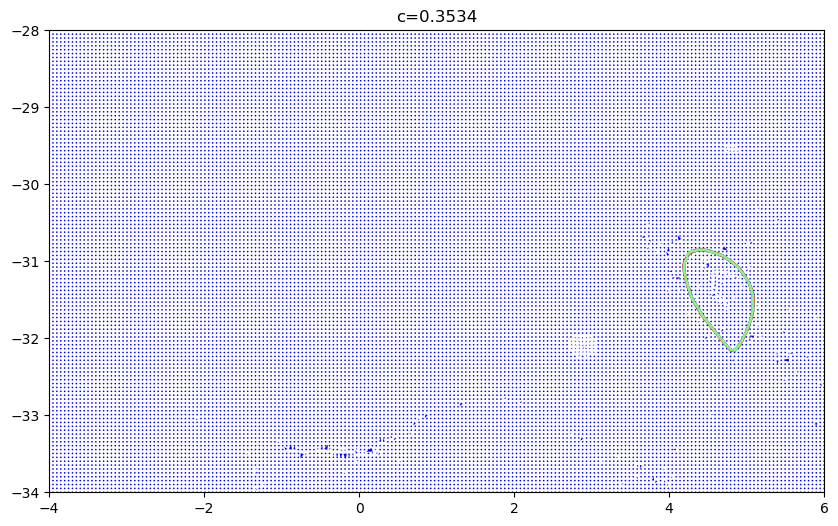

In [50]:
plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
# this is not completely straightforward due to the nonlinearity of softThreshold!
plot_vectorfield(get_levelset_evolution(ctx,S′[:,ev],S_dot[:,ev],bdata=bdata)...,ax,scale=0.15,step=1)
curves           = lines(get_levelset(ctx, S[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, Sϵ[:,ev],c_best,
                x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_predicted = lines(get_levelset(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),c_best,
                x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");